 # Metal Defect Analysis with Novelty Detection
 
 Improvements implemented:
 - Enhanced preprocessing with morphology
 - CNN with BatchNorm & Advanced Augmentation
 - Dynamic threshold calculation
 - PCA/K-Means visualizations
 - Novelty detection samples

In [25]:
# 0. Install Dependencies

#%%
%pip install keras-cv matplotlib seaborn plotly -q


Note: you may need to restart the kernel to use updated packages.


In [26]:
# ## 1. Enhanced Preprocessing with Visualization

# %%
import os
import cv2
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def enhanced_preprocess(img):
    """Improved preprocessing pipeline with morphology"""
    # Convert to grayscale if needed
    if len(img.shape) == 3 and img.shape[-1] == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img
    
    # Edge detection
    edges = cv2.Canny(gray, 100, 200)
    
    # Adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, 
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 11, 2)
    
    # Morphological closing
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    # Stack channels (gray, edges, morph)
    return np.dstack([gray, edges, morph])

def visualize_preprocessing(img_path):
    """Visualize preprocessing steps"""
    orig = cv2.imread(img_path)
    processed = enhanced_preprocess(orig)
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(2,4,1)
    plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))
    plt.title('Original')
    
    plt.subplot(2,4,2)
    plt.imshow(processed[:,:,0], cmap='gray')
    plt.title('Grayscale')
    
    plt.subplot(2,4,3)
    plt.imshow(processed[:,:,1], cmap='gray')
    plt.title('Edges')
    
    plt.subplot(2,4,4)
    plt.imshow(processed[:,:,2], cmap='gray')
    plt.title('Morph+Thresh')
    
    plt.subplot(2,1,2)
    plt.imshow(processed)
    plt.title('Stacked Channels')
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_preprocessing("path/to/your/image.bmp")


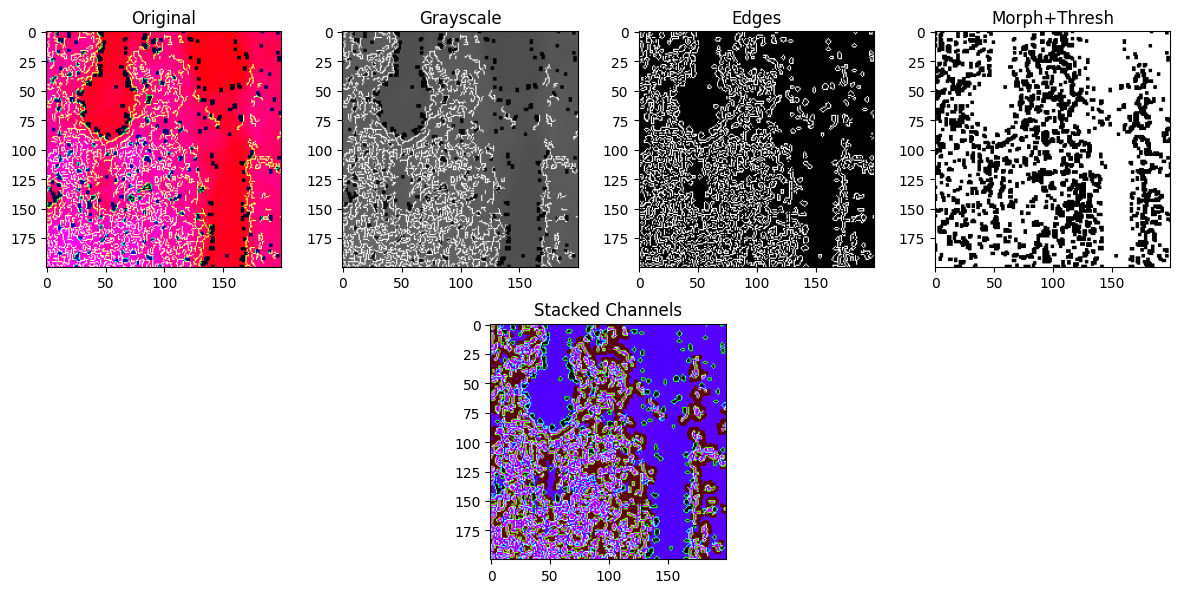

In [27]:
visualize_preprocessing("NEU_Metal_Surface_Defects_Data_Preproc/test/Patches/Pa_101.bmp")

In [28]:
# ## 2. Data Loading & Augmentation Visualization

# %%
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_generators(train_dir, valid_dir, test_dir, target_size=(200,200)):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        
        
        horizontal_flip=True
        
    )
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
        train_dir, target_size=target_size, batch_size=32, class_mode='categorical',shuffle=True)
    
    valid_gen = val_datagen.flow_from_directory(
        valid_dir, target_size=target_size, batch_size=32, class_mode='categorical',shuffle=False)
    
    test_gen = val_datagen.flow_from_directory(
        test_dir, target_size=target_size, batch_size=32, class_mode='categorical',shuffle=False)
    
    return train_gen, valid_gen, test_gen

def visualize_augmentations(generator):
    """Visualize augmented images"""
    images, _ = next(generator)
    
    plt.figure(figsize=(12,6))
    for i in range(8):
        plt.subplot(2,4,i+1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle('Augmented Training Samples')
    plt.show()

# Initialize generators
# train_gen, valid_gen, test_gen = create_generators(train_dir, valid_dir, test_dir)
# visualize_augmentations(train_gen)


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


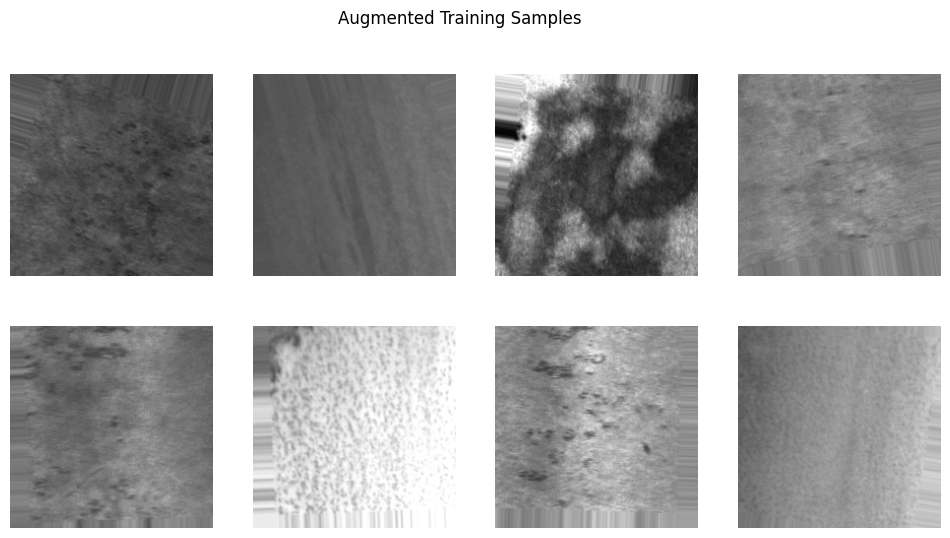

In [29]:
train_dir = "./NEU_Metal_Surface_Defects_Data/train"
test_dir = "./NEU_Metal_Surface_Defects_Data/test"
valid_dir = "./NEU_Metal_Surface_Defects_Data/valid"

train_gen, valid_gen, test_gen = create_generators(train_dir, valid_dir, test_dir)
visualize_augmentations(train_gen)

In [15]:
# ## 3. Enhanced CNN Architecture

# %%
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten

def build_enhanced_cnn(input_shape=(200,200,3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Conv2D(256, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

# model = build_enhanced_cnn()
# model.summary()


In [16]:
model = build_enhanced_cnn()
model.summary()

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737908279.248000   38757 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5761 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 198, 198, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 97, 97, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 46, 46, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 21, 21, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    13,107,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,501,126 (51.50 MB)

 Trainable params: 13,500,166 (51.50 MB)

 Non-trainable params: 960 (3.75 KB)

In [17]:
# ## 4. Training with Callbacks & Visualization

# %%
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def train_model(model, train_gen, valid_gen, epochs=10):
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.h5', save_best_only=True)
    ]
    
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=valid_gen,
        callbacks=callbacks
    )
    
    # Plot training history
    plt.figure(figsize=(12,5))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history

# history = train_model(model, train_gen, valid_gen)


/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1737908281.743244   39052 service.cc:148] XLA service 0x77be2c014c20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737908281.743264   39052 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-26 19:18:01.786104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737908282.012708   39052 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/52 ━━━━━━━━━━━━━━━━━━━━ 6:57 8s/step - accuracy: 0.1250 - loss: 3.5180

I0000 00:00:1737908288.133042   39052 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.4910 - loss: 14.9960

52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 286ms/step - accuracy: 0.4929 - loss: 14.9615 - val_accuracy: 0.3056 - val_loss: 40.1039
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.6803 - loss: 11.7779 - val_accuracy: 0.1944 - val_loss: 58.6070
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.7468 - loss: 8.4166 - val_accuracy: 0.0972 - val_loss: 47.2300
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.7469 - loss: 7.1128 - val_accuracy: 0.1667 - val_loss: 48.6864
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7789 - loss: 5.0375

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.7790 - loss: 5.0303 - val_accuracy: 0.1667 - val_loss: 37.2476
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7832 - loss: 6.1788

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.7828 - loss: 6.1808 - val_accuracy: 0.3194 - val_loss: 21.0177
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.7960 - loss: 3.4945 - val_accuracy: 0.3333 - val_loss: 21.2101
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.8454 - loss: 1.9665

52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.8452 - loss: 1.9641 - val_accuracy: 0.2361 - val_loss: 16.3181
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.8211 - loss: 2.0279 - val_accuracy: 0.3333 - val_loss: 19.3891
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.8617 - loss: 1.3761 - val_accuracy: 0.4583 - val_loss: 22.1662


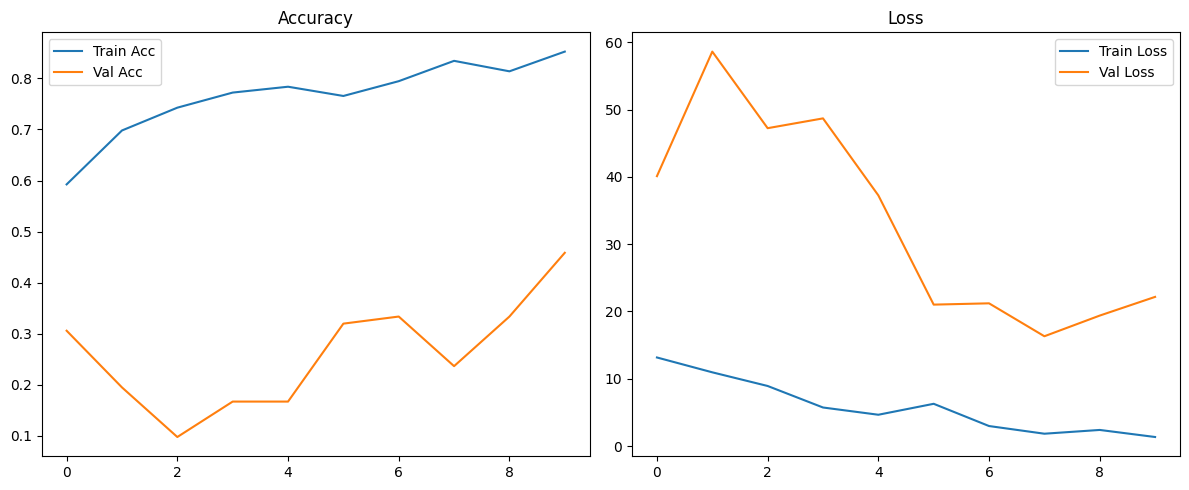

In [18]:
history = train_model(model, train_gen, valid_gen)

In [19]:
# ## 5. Evaluation Metrics

# %%
def evaluate_model(model, test_gen):
    # Confusion Matrix
    y_pred = model.predict(test_gen)
    y_pred = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Classification Report
    print(classification_report(y_true, y_pred, 
                               target_names=test_gen.class_indices.keys()))

# evaluate_model(model, test_gen)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


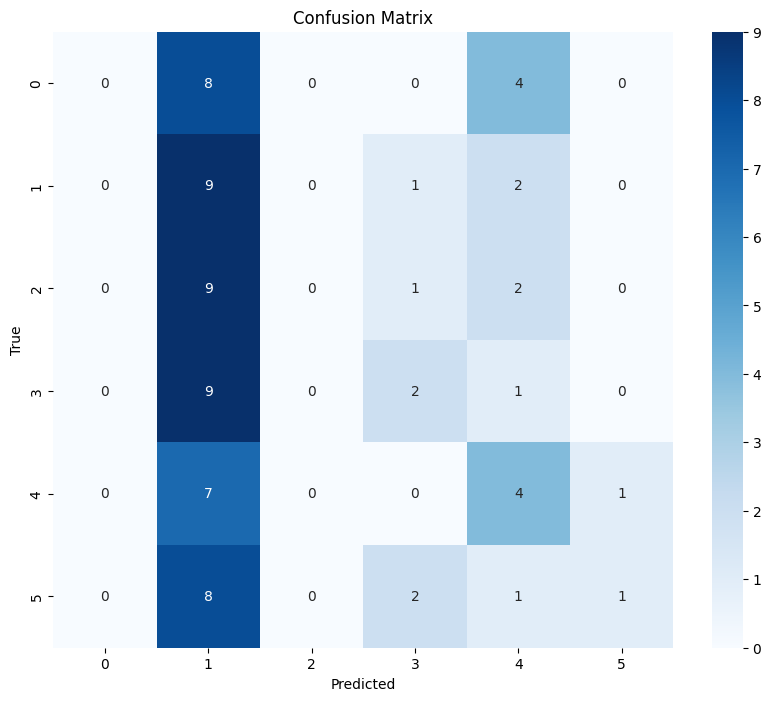

              precision    recall  f1-score   support

     Crazing       0.00      0.00      0.00        12
   Inclusion       0.18      0.75      0.29        12
     Patches       0.00      0.00      0.00        12
      Pitted       0.33      0.17      0.22        12
      Rolled       0.29      0.33      0.31        12
   Scratches       0.50      0.08      0.14        12

    accuracy                           0.22        72
   macro avg       0.22      0.22      0.16        72
weighted avg       0.22      0.22      0.16        72



/home/cago/MECH536/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cago/MECH536/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/cago/MECH536/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [20]:
evaluate_model(model, test_gen)

In [21]:
def extract_features(model, generator):
    """Returns features and class INDICES (not one-hot)"""
    feature_model = keras.Model(
        inputs=model.input,
        outputs=model.layers[-3].output
    )
    
    all_feats = []
    all_labels = []
    
    generator.reset()
    for _ in range(len(generator)):
        imgs, one_hot_labels = next(generator)
        feats = feature_model.predict(imgs, verbose=0)
        class_indices = np.argmax(one_hot_labels, axis=1)  # Convert from one-hot
        all_feats.append(feats)
        all_labels.append(class_indices)
    
    return np.concatenate(all_feats), np.concatenate(all_labels)

In [22]:
# ## 6. Feature Analysis & PCA Visualization

def visualize_features(features, labels, class_names=None):
    """Visualize features with proper label handling"""
    # Get class names from generator if available
    if class_names is None and hasattr(labels, 'class_indices'):
        class_names = list(labels.class_indices.keys())
    
    # PCA Visualization
    pca = PCA(n_components=3)
    pca_features = pca.fit_transform(features)
    
    # Variance plot
    plt.figure(figsize=(10,5))
    plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
    plt.title('PCA Explained Variance')
    plt.xlabel('Component')
    plt.ylabel('Variance Ratio')
    plt.show()
    
    # Create DataFrame for Plotly
    df = pd.DataFrame({
        'PC1': pca_features[:,0],
        'PC2': pca_features[:,1],
        'PC3': pca_features[:,2],
        'Class': [class_names[i] for i in labels] if class_names else labels
    })
    
    # 3D Interactive Plot
    fig = px.scatter_3d(
        df, x='PC1', y='PC2', z='PC3', 
        color='Class', 
        title='PCA Feature Space',
        labels={'color': 'Class'},
        hover_name='Class'
    )
    fig.show()

# Example usage:
# features, labels = extract_features(model, train_gen)
# visualize_features(features, labels)


In [23]:
features, labels = extract_features(model, train_gen)
visualize_features(features, labels)

AttributeError: The layer sequential has never been called and thus has no defined input.

In [9]:
# %%
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

def dynamic_kmeans(features, n_clusters=6):
    # Clustering
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters = km.fit_predict(features)
    
    # Dynamic threshold (95th percentile)
    distances = np.linalg.norm(features - km.cluster_centers_[clusters], axis=1)
    threshold = np.percentile(distances, 95)
    
    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42)
    tsne_features = tsne.fit_transform(features)
    
    plt.figure(figsize=(12,6))
    plt.scatter(tsne_features[:,0], tsne_features[:,1], 
                c=clusters, cmap='tab10', alpha=0.6)
    plt.title('t-SNE Cluster Visualization')
    plt.colorbar()
    plt.show()
    
    return km, threshold

# km, threshold = dynamic_kmeans(features)


In [ ]:
km, threshold = dynamic_kmeans(features)

In [10]:
# ## 8. Novelty Detection Visualization

# %%
def visualize_novelty(test_gen, novelty_flags, distances, threshold, num_samples=5):
    # Get novel samples
    novel_indices = np.where(novelty_flags)[0]
    if len(novel_indices) == 0:
        print("No novel samples detected!")
        return
    
    # Visualize top novel samples
    plt.figure(figsize=(15,8))
    for i, idx in enumerate(novel_indices[:num_samples]):
        img = test_gen[idx//test_gen.batch_size][0][idx%test_gen.batch_size]
        
        plt.subplot(2,num_samples,i+1)
        plt.imshow(img)
        plt.title(f"Dist: {distances[idx]:.2f}\nThreshold: {threshold:.2f}")
        plt.axis('off')
    
    plt.suptitle(f"Top {num_samples} Novel Samples", y=1.02)
    plt.tight_layout()
    plt.show()

# Example usage:
# visualize_novelty(test_gen, novelty_flags, distances, threshold)


In [ ]:
visualize_novelty(test_gen, novelty_flags, distances, threshold)

In [30]:
def save_preprocessed_dataset(source_root, dest_root, splits=["train","valid","test"], classes=None):
    """For each image in source_root/..., apply preprocess_image, save as BMP."""
    if classes is None:
        # or use a known list
        classes = os.listdir(os.path.join(source_root, splits[0]))
    
    for split in splits:
        for cls in classes:
            src_dir = os.path.join(source_root, split, cls)
            dst_dir = os.path.join(dest_root, split, cls)
            os.makedirs(dst_dir, exist_ok=True)
            
            for fname in os.listdir(src_dir):
                if not fname.lower().endswith(('.bmp')):
                    continue
                src_path = os.path.join(src_dir, fname)
                img = cv2.imread(src_path)
                if img is None:
                    print(f"Warning: failed to read {src_path}")
                    continue
                processed = enhanced_preprocess(img)
                outname = os.path.splitext(fname)[0] + ".bmp"
                outpath = os.path.join(dst_dir, outname)
                cv2.imwrite(outpath, processed)

In [5]:
# ## 9. Full Pipeline Execution

# %%
def main_pipeline():
    # Paths
    SOURCE_ROOT = "NEU_Metal_Surface_Defects_Data"
    DEST_ROOT = "NEU_Metal_Surface_Defects_Data_Preproc"
    
    # 1. Preprocessing
    save_preprocessed_dataset(SOURCE_ROOT, DEST_ROOT)
    
    # 2. Data Generators
    train_gen, valid_gen, test_gen = create_generators(
        os.path.join(DEST_ROOT, "train"),
        os.path.join(DEST_ROOT, "valid"), 
        os.path.join(DEST_ROOT, "test")
    )
    
    # 3. Build & Train Model
    model = build_enhanced_cnn()
    history = train_model(model, train_gen, valid_gen)
    
    # 4. Evaluate
    evaluate_model(model, test_gen)
    
    # 5. Feature Extraction
    features, labels = extract_features(model, train_gen)
    
    # 6. Feature Visualization
    class_names = list(train_gen.class_indices.keys())
    visualize_features(features, labels, class_names)
    
    # 7. Clustering
    km, threshold = dynamic_kmeans(features)
    
    # 8. Novelty Detection
    test_features, _ = extract_features(model, test_gen)
    test_clusters = km.predict(test_features)
    test_distances = np.linalg.norm(test_features - km.cluster_centers_[test_clusters], axis=1)
    novelty_flags = test_distances > threshold
    
    # 9. Visualize Novelty
    visualize_novelty(test_gen, novelty_flags, test_distances, threshold)

# if __name__ == "__main__":
#     main_pipeline()

In [ ]:
if __name__ == '__main__':
    main_pipeline()